In [1]:
## Parameters

# Tab settings
n_encoddings = 100          # Number of different drum encodings

# Audio settings
audio_sample_rate = 44100   # Keep at 22050Hz audio procesor will convert if higher
n_mels = 1024                # Number of freq divisions in Mel-Spectrogram
hop_length = 1024            # Audio samples averaged (used in the Mel-Spectrogram conversion) 

# Model settings
window_skip = 16            # Time steps skipped between predictions 
window_size = 64            # Time steps fed to the model a the same time
# The difference between size and skip allows some overlap between predictions, which then is resolved though voting.

# Model training
batch_size = 64            # Affects model training
num_epochs = 200

# Data settings
mp3_directory = 'data\\raw\MP3'
gp5_directory = 'data\\raw\GP5'

processed_data_directory = 'data\\processed'
joined_data_directory = 'data\\interim'

train_session_name = 'TestSession01'

In [2]:
# Data load and processing
from src.song_manager import SongManager

manager = SongManager()
manager.load_dataset(mp3_directory, gp5_directory, n_mels, window_size=window_size, skip=window_skip, hop_length=hop_length, sr=audio_sample_rate)
manager.save_processed_songs(output_directory=processed_data_directory)
manager.join_session_data(input_directory=processed_data_directory, output_directory=joined_data_directory, session_name=train_session_name)

#from sklearn.preprocessing import StandardScaler
# Create a scaler object
#scaler = StandardScaler()

# Fit and transform the X data
#X = scaler.fit_transform(X_i.reshape(-1, 1))
#X = X.reshape(X_i.shape)

In [9]:
import numpy as np
np.shape(manager.songs[0].audio_processor.audio_data)

(1024, 1273)

In [10]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)
print(tf.test.is_built_with_gpu_support())
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.keras import mixed_precision

policy_name = "mixed_float16"  # if you train on a GPU
policy = mixed_precision.Policy(policy_name)
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)


Num GPUs Available:  1
2.10.0
True
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5
Compute dtype: float16
Variable dtype: float32


In [11]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, Activation, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import he_normal, glorot_normal
from tensorflow import keras

#optimizer = keras.optimizers.Adam(lr=0.01)

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(window_size, n_mels)))
model.add(Dropout(0.2))
#model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(128,kernel_initializer=he_normal())) # Use Dense(1) for regression
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128,kernel_initializer=he_normal())) # Use Dense(1) for regression
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_encoddings, dtype='float32', activation='sigmoid')))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()



In [4]:
from src.visualization import visualize
from tensorflow.keras.models import load_model
import os

sesion_filepath = os.path.join(joined_data_directory,f"{train_session_name}.npz")
data_gen = manager.data_generator(sesion_filepath, batch_size)
total_batches = manager.get_batch_length(sesion_filepath, batch_size)
print(total_batches)

10


In [13]:
history = model.fit(
    manager.data_generator(sesion_filepath, batch_size),
    steps_per_epoch=total_batches,  # Calculate the steps per epoch based on your data size
    epochs=num_epochs
    # Add validation data if available
    # validation_data=val_data_gen,
    # validation_steps=val_total_samples // batch_size,
)
# OLD-------
#model = load_model('Models\DNET_V1.h5')
#history = model.fit(X, Y, epochs=2000, batch_size=batch_size, validation_split=0.5)
model.save('Models\DNET_V2.h5')  #creates a HDF5 file 'my_model.h5'


# visualize.plot_training_history(history)

Epoch 1/200
10/10 [==============================] - 4s 109ms/step - loss: 0.4815 - accuracy: 0.0098
Epoch 2/200
10/10 [==============================] - 1s 106ms/step - loss: 0.1143 - accuracy: 0.0063
Epoch 3/200
10/10 [==============================] - 1s 106ms/step - loss: 0.0133 - accuracy: 0.0176
Epoch 4/200
10/10 [==============================] - 1s 106ms/step - loss: 0.0079 - accuracy: 0.0285
Epoch 5/200
10/10 [==============================] - 1s 106ms/step - loss: 0.0075 - accuracy: 0.0292
Epoch 6/200
10/10 [==============================] - 1s 106ms/step - loss: 0.0072 - accuracy: 0.0303
Epoch 7/200
10/10 [==============================] - 1s 106ms/step - loss: 0.0068 - accuracy: 0.0305
Epoch 8/200
10/10 [==============================] - 1s 105ms/step - loss: 0.0065 - accuracy: 0.0311
Epoch 9/200
10/10 [==============================] - 1s 105ms/step - loss: 0.0061 - accuracy: 0.0294
Epoch 10/200
10/10 [==============================] - 1s 104ms/step - loss: 0.0059 - accura

In [14]:
print((manager.songs[0].audio_processor.n_mels))

1024


In [6]:
import matplotlib.pyplot as plt

def plot_training_history_logscale(history):
    plt.figure(figsize=(12, 4))
    
    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    #plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    #plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history_logscale(history)

NameError: name 'history' is not defined

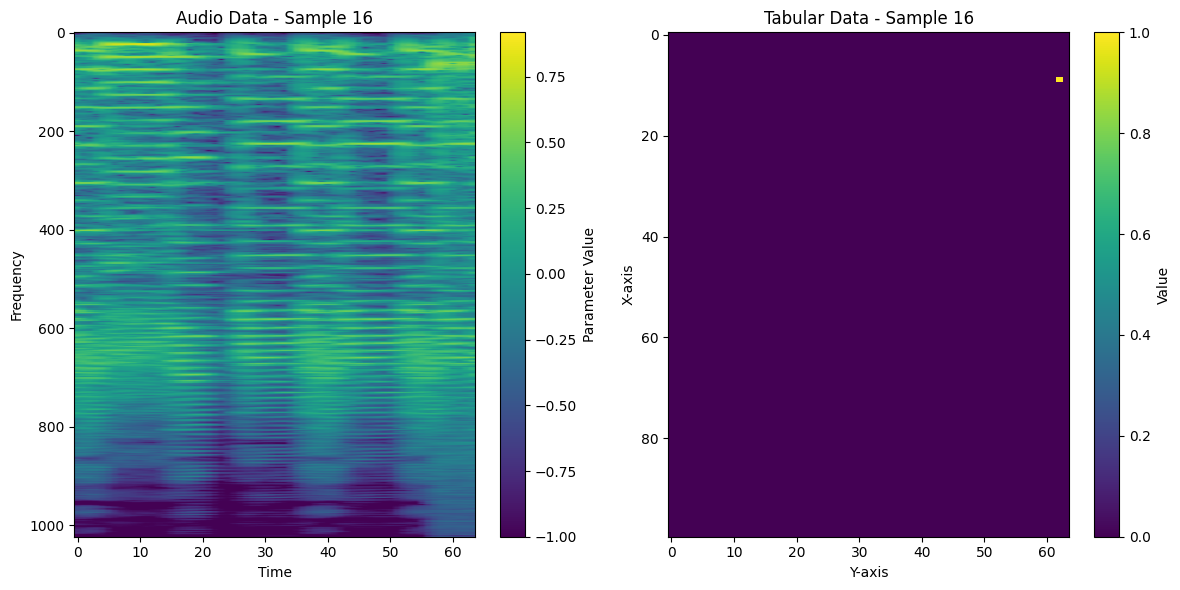

Shape of linear_data after reshaping: (1024, 64)


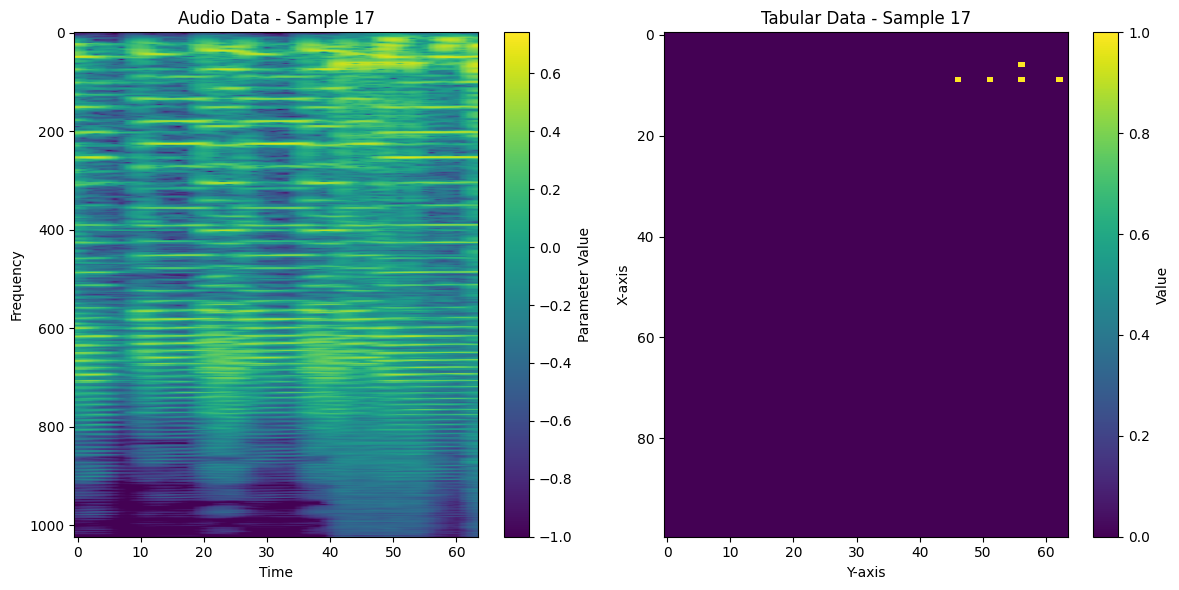

Shape of linear_data after reshaping: (1024, 64)


In [16]:
sample_batch = next(data_gen)  # Get one batch from the generator
import numpy as np
# Assuming the batch contains audio and tabular data
audio_data = sample_batch[0].numpy()  # Convert TensorFlow tensor to NumPy array
tabular_data = sample_batch[1].numpy()  # Convert TensorFlow tensor to NumPy array
import librosa
from IPython.display import Audio
from sklearn.preprocessing import MinMaxScaler
# Function to visualize data samples and reconstruct audio
def visualize_and_play_audio(audio_data, tabular_data):
    # Initialize MinMaxScaler for denormalization
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Fit the scaler on your audio data
    scaler.fit(audio_data.reshape(-1, 1))

    num_samples_to_visualize = 2
    sample_indices_with_non_zero = []

    for idx, sample in enumerate(tabular_data):
        if np.any(sample != 0):
            sample_indices_with_non_zero.append(idx)
            if len(sample_indices_with_non_zero) >= num_samples_to_visualize:
                break

    if len(sample_indices_with_non_zero) < num_samples_to_visualize:
        print(f"Found only {len(sample_indices_with_non_zero)} samples with non-zero values in tabular data.")
    else:
        for idx in sample_indices_with_non_zero:
            plt.figure(figsize=(12, 6))

            # Visualize audio data with scale
            plt.subplot(1, 2, 1)
            plt.imshow(audio_data[idx].T, aspect='auto')  # Transpose for X and Y axes exchange
            plt.colorbar(label='Parameter Value')  # Colorbar indicating the scale
            plt.title(f"Audio Data - Sample {idx}")
            plt.xlabel('Time')  # X-axis label
            plt.ylabel('Frequency')  # Y-axis label

            # Visualize tabular data with flipped axes
            plt.subplot(1, 2, 2)
            plt.imshow(tabular_data[idx].T, aspect='auto')  # Transpose for X and Y axes exchange
            plt.colorbar(label='Value')  # Colorbar indicating the scale
            plt.title(f"Tabular Data - Sample {idx}")
            plt.xlabel('Y-axis')  # X-axis label
            plt.ylabel('X-axis')  # Y-axis label

            plt.tight_layout()
            plt.show()

            # Reconstruct and play audio
            denormalized_data = scaler.inverse_transform(audio_data[idx].reshape(-1, 1))
            linear_data = librosa.db_to_power(denormalized_data.flatten(), ref=1.0)
            
            linear_data = linear_data.reshape(n_mels, 64)
            print("Shape of linear_data after reshaping:", linear_data.shape)


            # Invert mel power spectrogram to audio
            #reconstructed_audio = librosa.griffinlim(linear_data, n_fft=1022, hop_length=512, win_length=1022)
            # Play the reconstructed audio
            #audio_player = Audio(data=reconstructed_audio, rate=22050)
            #display(audio_player)
            
# Assuming 'sample_batch' contains audio and tabular data
audio_data = sample_batch[0].numpy()  # Convert TensorFlow tensor to NumPy array
tabular_data = sample_batch[1].numpy()  # Convert TensorFlow tensor to NumPy array

# Visualize the data and play reconstructed audio
visualize_and_play_audio(audio_data, tabular_data)

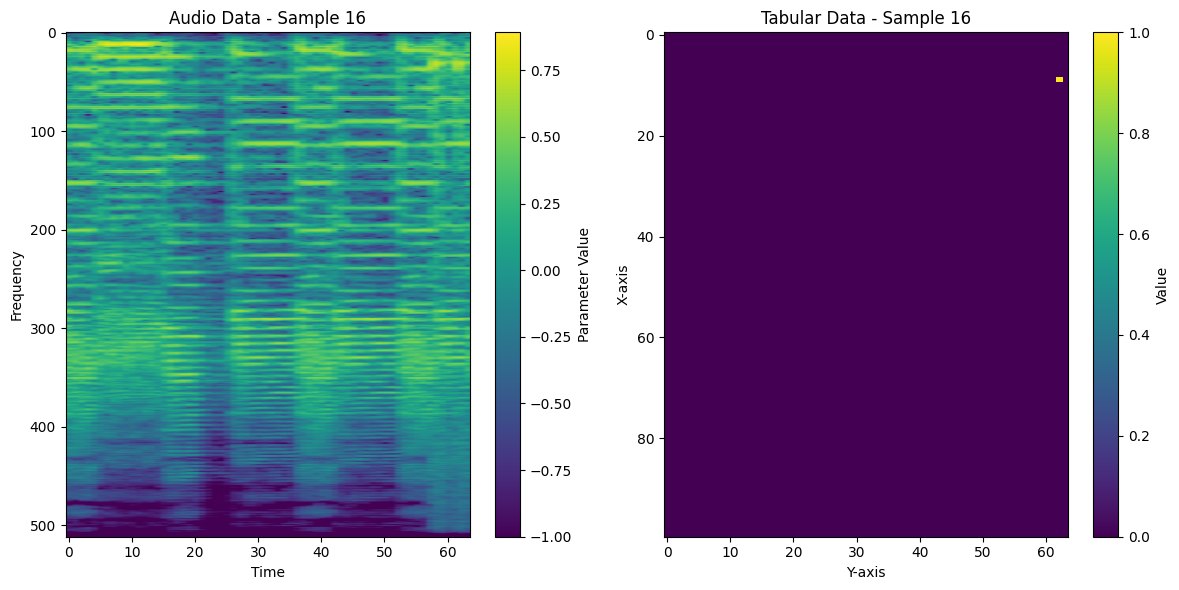

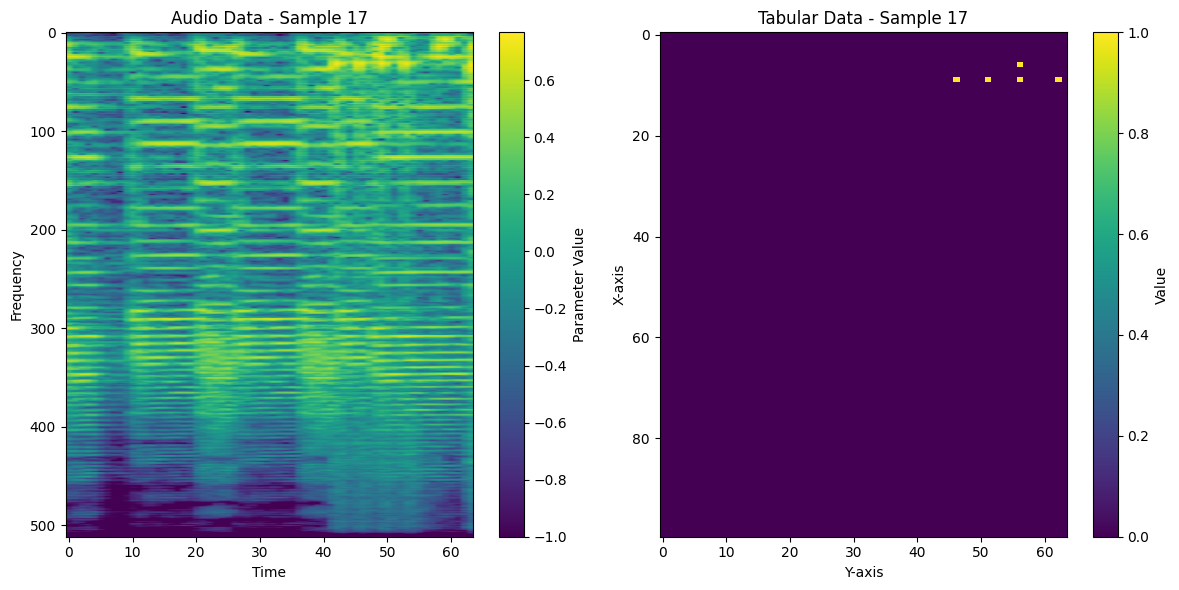

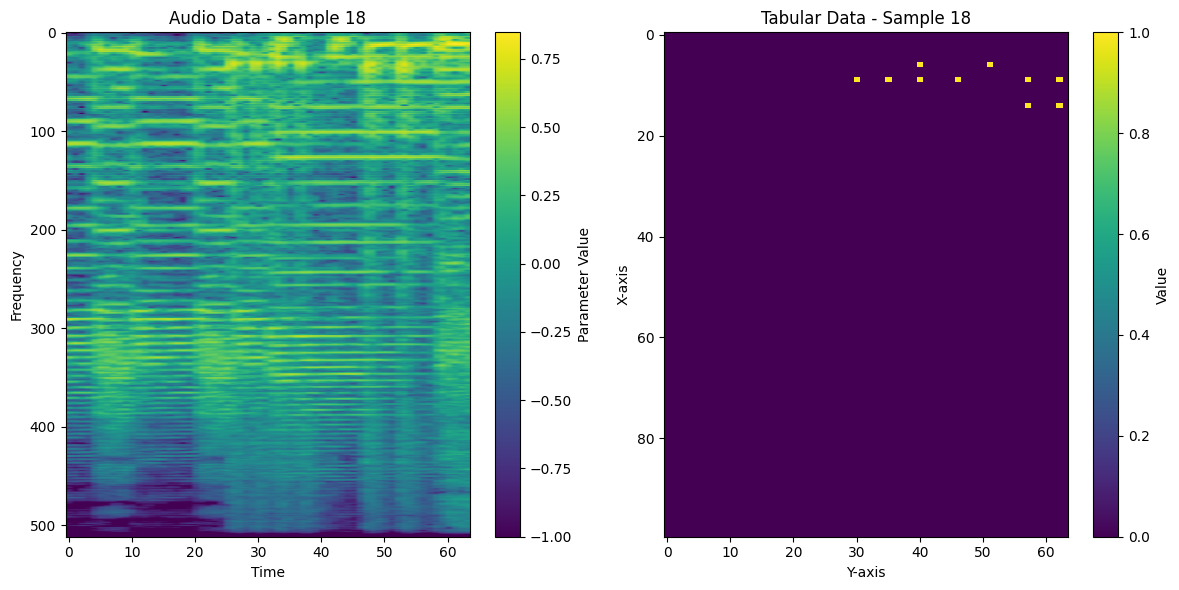

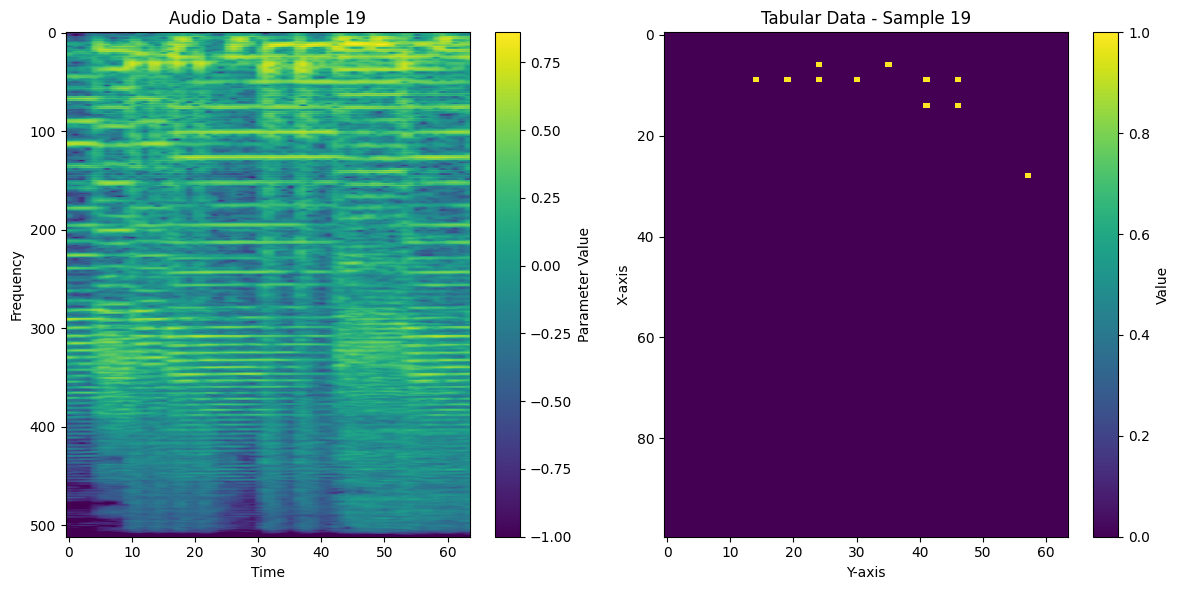

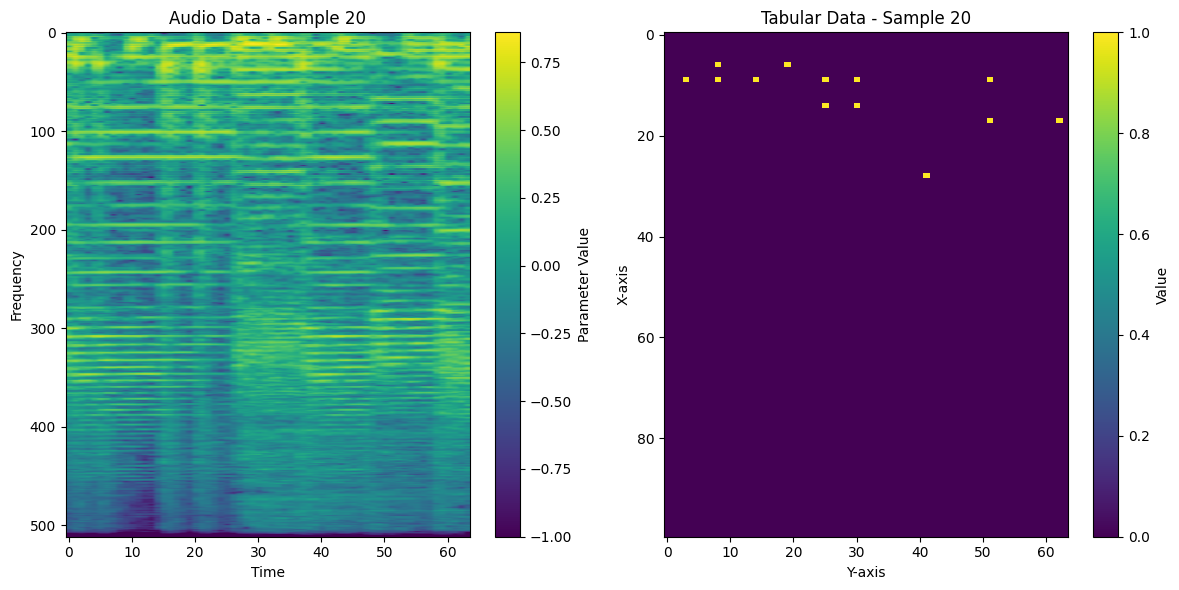

In [10]:

# Function to visualize data samples side by side
def visualize_data(audio_data, tabular_data):
    num_samples_to_visualize = 5
    sample_indices_with_non_zero = []
    
    for idx, sample in enumerate(tabular_data):
        if np.any(sample != 0):
            sample_indices_with_non_zero.append(idx)
            if len(sample_indices_with_non_zero) >= num_samples_to_visualize:
                break
    
    if len(sample_indices_with_non_zero) < num_samples_to_visualize:
        print(f"Found only {len(sample_indices_with_non_zero)} samples with non-zero values in tabular data.")
    else:
        for idx in sample_indices_with_non_zero:
            plt.figure(figsize=(12, 6))

            # Visualize audio data with scale
            plt.subplot(1, 2, 1)
            plt.imshow(audio_data[idx].T, aspect='auto')  # Transpose for X and Y axes exchange
            plt.colorbar(label='Parameter Value')  # Colorbar indicating the scale
            plt.title(f"Audio Data - Sample {idx}")
            plt.xlabel('Time')  # X-axis label
            plt.ylabel('Frequency')  # Y-axis label

            # Visualize tabular data with flipped axes
            plt.subplot(1, 2, 2)
            plt.imshow(tabular_data[idx].T, aspect='auto')  # Transpose for X and Y axes exchange
            plt.colorbar(label='Value')  # Colorbar indicating the scale
            plt.title(f"Tabular Data - Sample {idx}")
            plt.xlabel('Y-axis')  # X-axis label
            plt.ylabel('X-axis')  # Y-axis label

            plt.tight_layout()
            plt.show()

# Visualize the data
visualize_data(audio_data, tabular_data)

In [67]:
# Generate predictions for all examples in the validation dataset
thresholded_predictions = visualize.generate_thresholded_predictions(model, X, 0.5)
from sklearn.metrics import accuracy_score
true_acuracy = accuracy_score(Y.flatten(),thresholded_predictions.flatten())
print(true_acuracy)


NameError: name 'X' is not defined

In [12]:
from scipy import stats
import numpy as np
from scipy import stats

from scipy.stats import mode

def merge_windows(predictions, window_size, hop_size):
    """
    Merge overlapping windows of predictions into a single sequence using mode.
    
    Parameters:
    - predictions: 3D numpy array of shape (number of windows, window size, number of parameters).
    - window_size: The size of each window.
    - hop_size: The step size to move the window.
    
    Returns:
    - A single sequence of predictions.
    """

    num_windows, win_size, num_params = predictions.shape
    assert win_size == window_size, "Provided window size does not match the predictions shape."

    # Initialize a list to hold all predictions for each time step
    merged_predictions_list = [[[] for _ in range(num_params)] for _ in range((num_windows-1) * hop_size + window_size)]

    # Loop over each window of predictions
    for window_start in range(0, num_windows * hop_size, hop_size):
        window_end = window_start + window_size
        for i, timestep in enumerate(range(window_start, window_end)):
            for j in range(num_params):
                merged_predictions_list[timestep][j].append(predictions[int(window_start/hop_size)][i][j])

    # Determine mode for each timestep
    merged_predictions = np.zeros((len(merged_predictions_list), num_params))
    for i in range(len(merged_predictions_list)):
        for j in range(num_params):
            mode_val = mode(merged_predictions_list[i][j])[0]
            if np.isscalar(mode_val):
                merged_predictions[i][j] = mode_val
            else:
                merged_predictions[i][j] = mode_val[0]
    return merged_predictions

def merge_windows(predictions, window_size, hop_size):
    num_windows, win_size, num_params = predictions.shape
    assert win_size == window_size, "Provided window size does not match the predictions shape."

    # Define the size of the merged array
    merged_length = (num_windows-1) * hop_size + window_size
    merged_predictions = np.zeros((merged_length, num_params))

    # Create an overlap counter
    overlap_counter = np.zeros((merged_length, num_params))

    # Accumulate predictions and overlap count
    for window_start in range(0, num_windows * hop_size, hop_size):
        window_end = window_start + window_size
        merged_predictions[window_start:window_end] += predictions[int(window_start/hop_size)]
        overlap_counter[window_start:window_end] += 1

    # Calculate mode: Since you likely have binary values, you can determine mode by checking if the sum is > 0.5 * overlap_counter
    merged_predictions = np.where(merged_predictions > 0.5 * overlap_counter, 1, 0)

    return merged_predictions

# Usage:
merged_predictions = merge_windows(thresholded_predictions, window_size, window_skip)
merged_real_tabs = merge_windows(Y, window_size, window_skip)
merged_x = []

for song in manager.songs:
    merged_x.append(song.audio_processor.audio_data.T)

# Convert list of arrays to a single concatenated numpy array
merged_X = np.concatenate(merged_x, axis=0)


NameError: name 'thresholded_predictions' is not defined

In [34]:
# Reverse the dictionary

mapping = {0: -1}
for idx, num in enumerate(range(29, 128)):
    mapping[num] = idx


reverse_dict = {v: k for k, v in mapping.items()}

def one_hot_to_encoding(one_hot_prediction, reverse_dict):
    hit_indices = np.argwhere(one_hot_prediction > 0)
    # Create an array with -1 for no hit
    encoding = np.full((one_hot_prediction.shape[0], 4), -1)
    
    # For each time step, fill in the hit values (up to 4)
    for t in range(one_hot_prediction.shape[0]):
        hits = hit_indices[hit_indices[:,0] == t]
        for i in range(len(hits)):
            hits[i, 1] = reverse_dict[hits[i, 1]]
        encoding[t,:len(hits)] = hits[:,1] # Use the dictionary to map to original encoding values
    
    return encoding

# Transform prediction
Y_pred_encoding = one_hot_to_encoding(merged_predictions, reverse_dict)
Y_pred_encoding = np.where(Y_pred_encoding == -1, 0, Y_pred_encoding)


Y_real = one_hot_to_encoding(merged_real_tabs, reverse_dict)
Y_real = np.where(Y_real == -1, 0, Y_real)

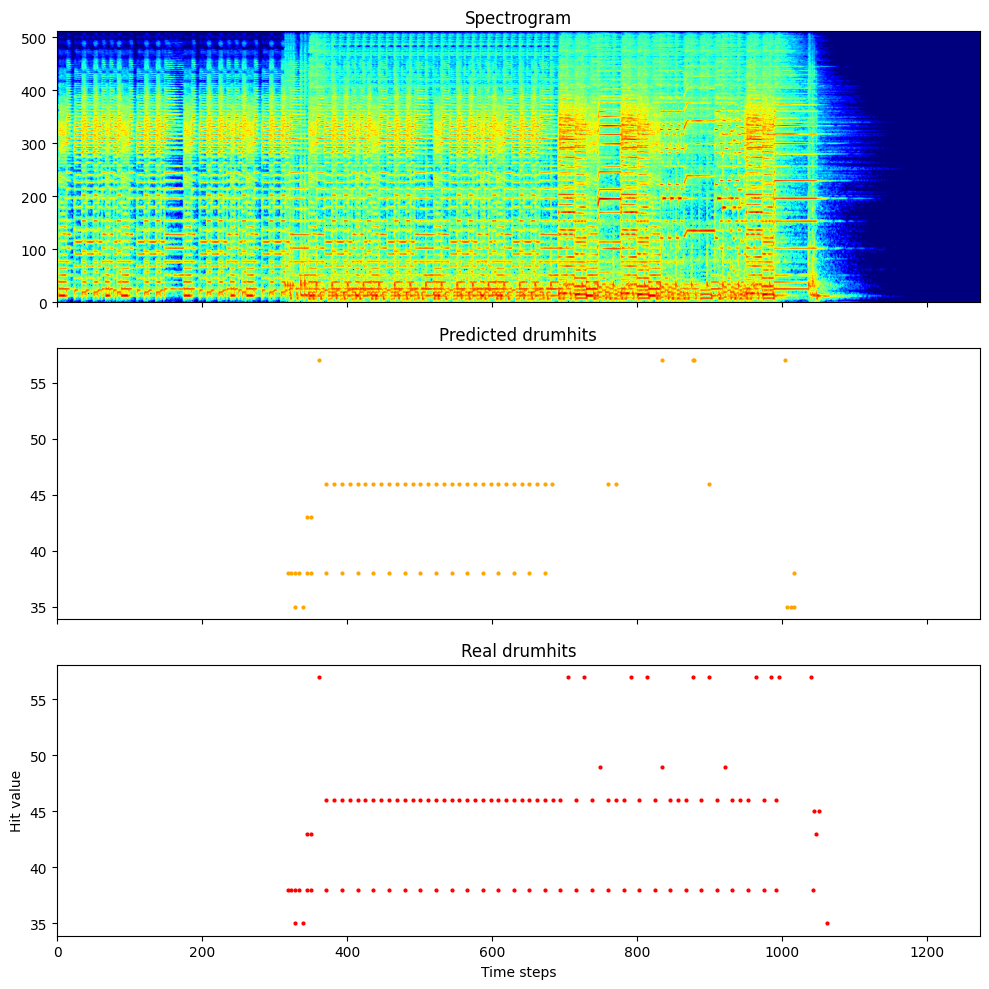

In [35]:
import matplotlib.pyplot as plt
import librosa
# Assuming the spectrogram is stored in a variable called "spectrogram"
# And the one-hot predictions are stored in a variable called "predictions"

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))

# Plotting the spectrogram
ax[0].imshow(merged_X.T, aspect='auto', cmap='jet', origin='lower')
ax[0].set_title('Spectrogram')

# Plotting the predicted drumhits
data = Y_pred_encoding  # Dummy data
for i in range(4):
    # Find where data is not 0
    hits = data[:, i] != 0
    
    ax[1].plot(np.arange(len(data))[hits], data[hits, i], marker='o', linestyle='', markersize=2, color='orange', label=f'Drum hit {i+1}')
plt.xlabel('Time steps')
plt.ylabel('Hit value')
ax[1].set_title('Predicted drumhits')

# Plotting the real drumhits
data = Y_real  # Dummy data
for i in range(4):
    # Find where data is not 0
    hits = data[:, i] != 0
    
    ax[2].plot(np.arange(len(data))[hits], data[hits, i], marker='o', linestyle='', markersize=2, color='red', label=f'Drum hit {i+1}')

plt.xlabel('Time steps')
plt.ylabel('Hit value')
ax[2].set_title('Real drumhits')

plt.tight_layout()
plt.show()

#S = librosa.feature.inverse.mel_to_stft(merged_X.T)
#y = librosa.griffinlim(S)


In [12]:
import IPython.display as ipd
from pydub import AudioSegment
from pydub.playback import play
from IPython.display import Audio

#audio_segment = AudioSegment(
#    y.tobytes(),
#    frame_rate=22050,
#    sample_width=y.dtype.itemsize,
#    channels=1  # For mono audio, use 2 for stereo
#)
#Audio(data=y, rate=22050)
#sr = 22050 # sample rate
#ipd.Audio(y, rate=sr, autoplay=True) # load a NumPy array


ModuleNotFoundError: No module named 'pydub'

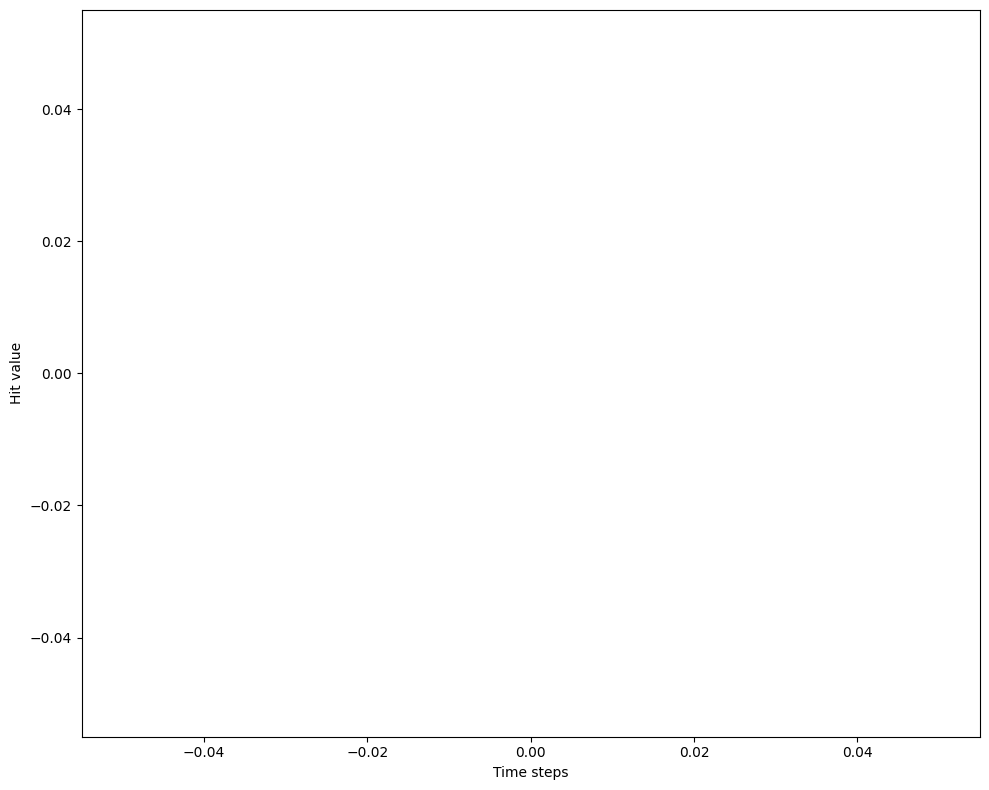

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
# Assuming `data` is your 2D array of shape (time_steps, 4)
data = merged_real_tabs.T  # Dummy data

colors = ['blue', 'orange', 'green', 'red']

for i in range(4):
    # Find where data is not 0
    hits = data[:, i] != 0
    
    ax.plot(np.arange(len(data))[hits], data[hits, i], marker='o', linestyle='', markersize=2, color='orange', label=f'Drum hit {i+1}')

plt.xlabel('Time steps')
plt.ylabel('Hit value')
plt.tight_layout()
plt.show()
